<h1>光頭傑夫製作</h1><img src="https://rolqiw.bl.files.1drv.com/y4mYqkObWmQmdJFd8pab8t8m7d_mFhh3_YG63fiAnPaG6gjahHFt0n087pF97x1W2wemm7hd4ZdiPD2OxoPtqcCD_4-Jy-fojnt97kGGWR4Hnq0-9Ny61afd7WVHVTmF_9pcr45OFDFSwLKByeQU1q9TjwKk-HsNmWVsW1eGQ4Gi-9G4pQ5DYoTxswYJ5r5dLF-kKsA1InEyrqmV3kF5pm4WQ?width=658&height=584&cropmode=none" width=160px align="left" />

### <span style="color:red ">以下是我們需要的量化分析套件:
---    
    1. Jupyter Notebook環境中，第一次安裝過就好，以後直接導入模組就好。
    2. 如果你是在Colab的環境中運作檔案，請每次安裝

! pip install backtrader

### <span style="color:red ">以下是我們後續輸出分析結果需要的方程式:
---    
    1. 每次你要輸出策略的績效結果時，下面這格你都要跑

In [1]:
def printTradeAnalysis(analyzer):
    '''
    Function to print the Technical Analysis results in a nice format.
    '''
    #Get the results we are interested in
    total_closed = ''
    total_won =''
    total_lost =''
    win_streak = ''
    lose_streak = ''
    pnl_net =''
    strike_rate =''
    
    if len(analyzer.total)>2:
        total_closed = analyzer.total.closed
        total_won = analyzer.won.total
        total_lost = analyzer.lost.total
        win_streak = analyzer.streak.won.longest
        lose_streak = analyzer.streak.lost.longest
        pnl_net = round(analyzer.pnl.net.total,2)
    
    if total_closed:
        strike_rate=round((total_won / total_closed) * 100,2)
    else:
        strike_rate='沒有完整交易'
    print("策略運作分析結果:")
    print(f'獲利累積次數 : {str(total_won)}')
    print(f'損失累積次數 : {str(total_lost)}')
    print(f'獲利損失次數比 : {str(strike_rate)}')
    print(f'最高連續獲利交易次數 : {str(win_streak)}')
    print(f'最高連續損失交易次數 : {str(lose_streak)}')
    print(f'淨利結算 : {str(pnl_net)}')
    

## <span style="color:red ">  <策略1-with Commision>用MACD做個回測策略吧!
---
### 先回想一下，MACD是什麼意思?
    
    我們測定策略如下:
    1.先找第一條線-DIF線(紅線，快線)
    
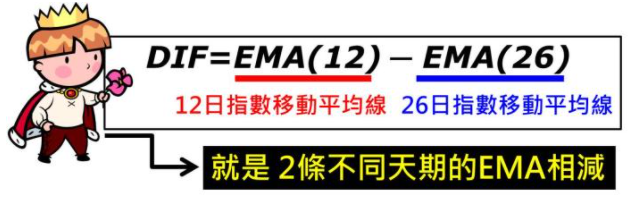

2. 再找第二條線-MACD線(藍線，慢線)
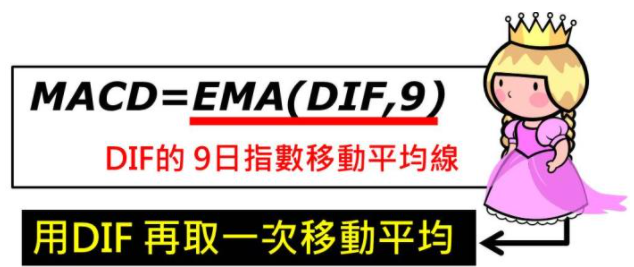

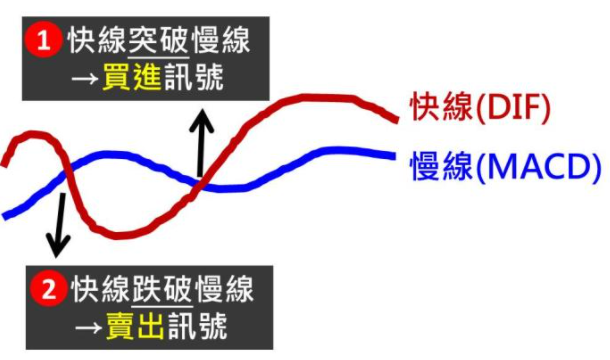

### <span style="color:red "><策略1.1- with Commision>導入需求模組

In [2]:
from datetime import datetime
import pandas as pd
import yfinance as yf
import backtrader as bt

### <span style="color:red "><策略1.2- with Commision>建立交易策略

In [13]:
class MACDStrategy(bt.Strategy):
   
    # Standard MACD Parameters
    params = dict(
        macd1=5, 
        macd2=23,
        macdsig=12
        
    )

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data,
                                       period_me1=self.p.macd1,
                                       period_me2=self.p.macd2,
                                       period_signal=self.p.macdsig)

        # Cross of macd.macd and macd.signal
        self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
        self.order = None

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'買單執行 --- 買價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'賣單執行 --- 賣價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失敗')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'運作結果 --- 獲利狀況: {trade.pnl:.2f}, 淨獲利: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            if self.mcross[0] > 0.0: 
                self.log(f'開出買單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.buy(size=1000)

        else:
            # sell condition
            if self.mcross[0] < 0.0:
                self.log(f'開出賣單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.sell(size=1000)

### <span style="color:red "><策略1.3- with Commision>抓取目標股票的歷史資料

In [4]:
data= yf.download(  '2330.tw',              #股票代碼
                    start='2022-3-30',      #資料開始日期
                    end='2023-3-30',         #資料結束日期
                    progress=False
                 )
print(data)
data=bt.feeds.PandasData(dataname=pd.DataFrame({'open': data['Open'], 
                   'high': data['High'],
                   'low': data['Low'],
                   'close': data['Close'],
                   'volume': data['Volume'],
                  }))

             Open   High    Low  Close   Adj Close    Volume
Date                                                        
2022-03-30  599.0  600.0  597.0  600.0  586.769043  41230239
2022-03-31  602.0  602.0  594.0  597.0  583.835144  22700114
2022-04-01  585.0  589.0  584.0  589.0  576.011597  29732696
2022-04-06  578.0  580.0  575.0  578.0  565.254150  37645873
2022-04-07  571.0  573.0  566.0  566.0  553.518799  42904743
...           ...    ...    ...    ...         ...       ...
2023-03-22  524.0  533.0  524.0  533.0  533.000000  42385987
2023-03-23  528.0  539.0  528.0  538.0  538.000000  26728246
2023-03-24  536.0  539.0  535.0  539.0  539.000000  21926240
2023-03-27  533.0  536.0  531.0  531.0  531.000000  16111177
2023-03-28  525.0  530.0  524.0  525.0  525.000000  17234120

[243 rows x 6 columns]


### <span style="color:red "><策略1.4- with Commision>建立台股交易費用計算模式

In [5]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)


### <span style="color:red "><策略1.5- with Commision>建立回測分析「大腦」

In [14]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

# create a Cerebro entity
cerebro = bt.Cerebro()

# set up the backtest
cerebro.adddata(data)
cerebro.broker.setcash(cash)
cerebro.addstrategy(MACDStrategy)

#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=20
)

cerebro.broker.addcommissioninfo(comminfo)


### <span style="color:red "><策略1.6- with Commision>讓Analyzers來幫我診斷策略細節...-開始回測

In [15]:
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")

strategies = cerebro.run()
firstStrat = strategies[0]

# print the analyzers
printTradeAnalysis(firstStrat.analyzers.ta.get_analysis())
print(f'持有資產總值: {cerebro.broker.getvalue():.2f}')

2022-07-11, 開出買單 --- 當時市場價格: 462.00
2022-07-12, 買單執行 --- 買價: 458.00, 成本: 458000.00, 手續費: 130.53
2022-08-22, 開出賣單 --- 當時市場價格: 512.00
2022-08-23, 賣單執行 --- 賣價: 503.00, 成本: 458000.00, 手續費: 1652.36
2022-08-23, 運作結果 --- 獲利狀況: 45000.00, 淨獲利: 43217.11
2022-10-06, 開出買單 --- 當時市場價格: 451.00
2022-10-07, 買單執行 --- 買價: 448.50, 成本: 448500.00, 手續費: 127.82
2022-10-11, 開出賣單 --- 當時市場價格: 401.50
2022-10-12, 賣單執行 --- 賣價: 397.00, 成本: 448500.00, 手續費: 1304.14
2022-10-12, 運作結果 --- 獲利狀況: -51500.00, 淨獲利: -52931.97
2022-10-27, 開出買單 --- 當時市場價格: 385.50
2022-10-28, 買單執行 --- 買價: 379.50, 成本: 379500.00, 手續費: 108.16
2022-11-29, 開出賣單 --- 當時市場價格: 487.00
2022-11-30, 賣單執行 --- 賣價: 483.00, 成本: 379500.00, 手續費: 1586.65
2022-11-30, 運作結果 --- 獲利狀況: 103500.00, 淨獲利: 101805.19
2023-01-06, 開出買單 --- 當時市場價格: 458.50
2023-01-09, 買單執行 --- 買價: 468.00, 成本: 468000.00, 手續費: 133.38
2023-02-14, 開出賣單 --- 當時市場價格: 545.00
2023-02-15, 賣單執行 --- 賣價: 526.00, 成本: 468000.00, 手續費: 1727.91
2023-02-15, 運作結果 --- 獲利狀況: 58000.00, 淨獲利: 56138.71
2023-03-22, 開出買單 ---

### <span style="color:red "><策略1.7- with Commision>畫張圖勝過千言萬語!-圖形化表達

<IPython.core.display.Javascript object>


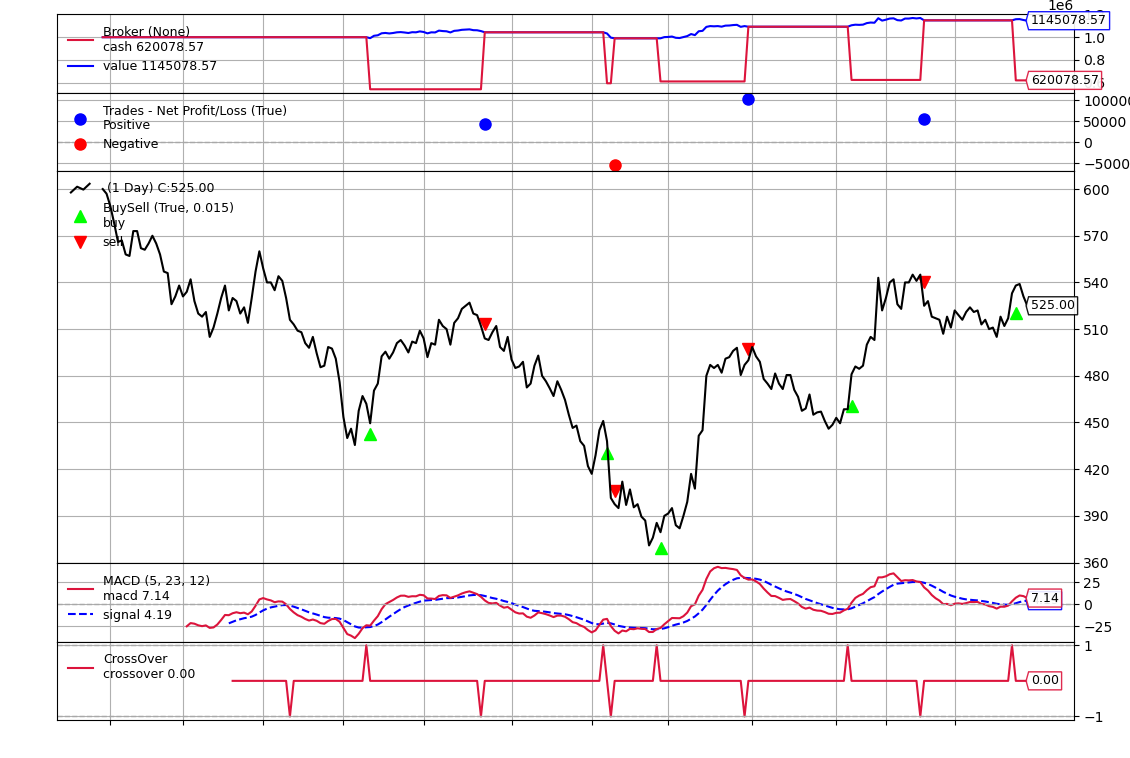

[[<Figure size 512x384 with 5 Axes>]]

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.dpi']=80
# plot results
cerebro.plot(iplot=True, volume=False)

### <span style="color:red "><策略2- with Commision>我們想要來個參數特調MACD看看效果怎麼樣?
--------

### <span style="color:red "><策略2.2- with Commision>建立交易策略

In [18]:
class MACDStrategy(bt.Strategy):
    # Standard MACD Parameters
    params = dict(
        macd1=12, 
        macd2=26,
        macdsig=9,
        totalValue=''
    )
    def __init__(self):
        self.macd = bt.indicators.MACD(self.data,
                                       period_me1=self.p.macd1,
                                       period_me2=self.p.macd2,
                                       period_signal=self.p.macdsig)

        # Cross of macd.macd and macd.signal
        self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
        self.order = None

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            if self.mcross[0] > 0.0: 
                self.order = self.buy(size=1000)

        else:
            # sell condition
            if self.mcross[0] < 0.0:
                self.order = self.sell(size=1000)
    def stop(self):
        self.log(f'(紅線週期組合=({self.params.macd1:2d}天,{self.params.macd2:2d}天)---藍線週期設定 = {self.params.macdsig:2d}天) --- 淨利數值: {self.broker.getvalue()-cash:.2f}')
        self.params.totalValue=self.broker.getvalue()

### <span style="color:red "><策略2.4- with Commision>建立台股交易費用計算模式

In [19]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略2.5- with Commision>建立回測分析「大腦」,讓Analyzers來幫我診斷策略細節...-開始回測

In [12]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

# create a Cerebro entity
cerebro = bt.Cerebro()
cerebro.optstrategy(MACDStrategy,macd1=range(5,12),macd2=range(20,40),macdsig=range(6,13))
cerebro.adddata(data)
cerebro.broker.setcash(cash)

#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=20
)


cerebro.broker.addcommissioninfo(comminfo)

cerebro.addanalyzer(bt.analyzers.TradeAnalyzer,_name="ta")

opt_runs = cerebro.run(maxcpus=1)


for run in opt_runs:
    for strategy in run:
        print(f'紅線週期組合=({strategy.params.macd1:2d}天,{strategy.params.macd2:2d}天)---藍線週期設定 = {strategy.params.macdsig:2d}天)')
        try:
            printTradeAnalysis(strategy.analyzers.ta.get_analysis())
        except KeyError :
            print('沒有交易發生')
        print(f'持有資產總值: {strategy.params.totalValue:.2f}')
        print('--------------------------------------------------------')

2023-03-28, (紅線週期組合=( 5天,20天)---藍線週期設定 =  6天) --- 淨利數值: 49278.15
2023-03-28, (紅線週期組合=( 5天,20天)---藍線週期設定 =  7天) --- 淨利數值: 48555.71
2023-03-28, (紅線週期組合=( 5天,20天)---藍線週期設定 =  8天) --- 淨利數值: 57128.78
2023-03-28, (紅線週期組合=( 5天,20天)---藍線週期設定 =  9天) --- 淨利數值: 86843.98
2023-03-28, (紅線週期組合=( 5天,20天)---藍線週期設定 = 10天) --- 淨利數值: 115357.04
2023-03-28, (紅線週期組合=( 5天,20天)---藍線週期設定 = 11天) --- 淨利數值: 141141.12
2023-03-28, (紅線週期組合=( 5天,20天)---藍線週期設定 = 12天) --- 淨利數值: 145273.74
2023-03-28, (紅線週期組合=( 5天,21天)---藍線週期設定 =  6天) --- 淨利數值: 37743.16
2023-03-28, (紅線週期組合=( 5天,21天)---藍線週期設定 =  7天) --- 淨利數值: 52213.38
2023-03-28, (紅線週期組合=( 5天,21天)---藍線週期設定 =  8天) --- 淨利數值: 63130.49
2023-03-28, (紅線週期組合=( 5天,21天)---藍線週期設定 =  9天) --- 淨利數值: 101911.68
2023-03-28, (紅線週期組合=( 5天,21天)---藍線週期設定 = 10天) --- 淨利數值: 131173.98
2023-03-28, (紅線週期組合=( 5天,21天)---藍線週期設定 = 11天) --- 淨利數值: 142456.33
2023-03-28, (紅線週期組合=( 5天,21天)---藍線週期設定 = 12天) --- 淨利數值: 141246.58
2023-03-28, (紅線週期組合=( 5天,22天)---藍線週期設定 =  6天) --- 淨利數值: 63025.93
2023-03-28, (紅線週期組

2023-03-28, (紅線週期組合=( 5天,38天)---藍線週期設定 =  6天) --- 淨利數值: 109642.44
2023-03-28, (紅線週期組合=( 5天,38天)---藍線週期設定 =  7天) --- 淨利數值: 96183.02
2023-03-28, (紅線週期組合=( 5天,38天)---藍線週期設定 =  8天) --- 淨利數值: 153237.51
2023-03-28, (紅線週期組合=( 5天,38天)---藍線週期設定 =  9天) --- 淨利數值: 149042.22
2023-03-28, (紅線週期組合=( 5天,38天)---藍線週期設定 = 10天) --- 淨利數值: 127548.59
2023-03-28, (紅線週期組合=( 5天,38天)---藍線週期設定 = 11天) --- 淨利數值: 125047.87
2023-03-28, (紅線週期組合=( 5天,38天)---藍線週期設定 = 12天) --- 淨利數值: 128866.19
2023-03-28, (紅線週期組合=( 5天,39天)---藍線週期設定 =  6天) --- 淨利數值: 109642.44
2023-03-28, (紅線週期組合=( 5天,39天)---藍線週期設定 =  7天) --- 淨利數值: 96183.02
2023-03-28, (紅線週期組合=( 5天,39天)---藍線週期設定 =  8天) --- 淨利數值: 153237.51
2023-03-28, (紅線週期組合=( 5天,39天)---藍線週期設定 =  9天) --- 淨利數值: 149042.22
2023-03-28, (紅線週期組合=( 5天,39天)---藍線週期設定 = 10天) --- 淨利數值: 125047.87
2023-03-28, (紅線週期組合=( 5天,39天)---藍線週期設定 = 11天) --- 淨利數值: 128866.19
2023-03-28, (紅線週期組合=( 5天,39天)---藍線週期設定 = 12天) --- 淨利數值: 107078.44
2023-03-28, (紅線週期組合=( 6天,20天)---藍線週期設定 =  6天) --- 淨利數值: 37743.16
2023-03-28, (

2023-03-28, (紅線週期組合=( 6天,36天)---藍線週期設定 =  6天) --- 淨利數值: 102684.88
2023-03-28, (紅線週期組合=( 6天,36天)---藍線週期設定 =  7天) --- 淨利數值: 140570.14
2023-03-28, (紅線週期組合=( 6天,36天)---藍線週期設定 =  8天) --- 淨利數值: 163240.36
2023-03-28, (紅線週期組合=( 6天,36天)---藍線週期設定 =  9天) --- 淨利數值: 131037.09
2023-03-28, (紅線週期組合=( 6天,36天)---藍線週期設定 = 10天) --- 淨利數值: 127869.47
2023-03-28, (紅線週期組合=( 6天,36天)---藍線週期設定 = 11天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=( 6天,36天)---藍線週期設定 = 12天) --- 淨利數值: 107078.44
2023-03-28, (紅線週期組合=( 6天,37天)---藍線週期設定 =  6天) --- 淨利數值: 96183.02
2023-03-28, (紅線週期組合=( 6天,37天)---藍線週期設定 =  7天) --- 淨利數值: 163494.59
2023-03-28, (紅線週期組合=( 6天,37天)---藍線週期設定 =  8天) --- 淨利數值: 149042.22
2023-03-28, (紅線週期組合=( 6天,37天)---藍線週期設定 =  9天) --- 淨利數值: 128536.38
2023-03-28, (紅線週期組合=( 6天,37天)---藍線週期設定 = 10天) --- 淨利數值: 128866.19
2023-03-28, (紅線週期組合=( 6天,37天)---藍線週期設定 = 11天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=( 6天,37天)---藍線週期設定 = 12天) --- 淨利數值: 107078.44
2023-03-28, (紅線週期組合=( 6天,38天)---藍線週期設定 =  6天) --- 淨利數值: 100383.05
2023-03-28,

2023-03-28, (紅線週期組合=( 7天,34天)---藍線週期設定 =  6天) --- 淨利數值: 128573.86
2023-03-28, (紅線週期組合=( 7天,34天)---藍線週期設定 =  7天) --- 淨利數值: 163494.59
2023-03-28, (紅線週期組合=( 7天,34天)---藍線週期設定 =  8天) --- 淨利數值: 131037.09
2023-03-28, (紅線週期組合=( 7天,34天)---藍線週期設定 =  9天) --- 淨利數值: 125047.87
2023-03-28, (紅線週期組合=( 7天,34天)---藍線週期設定 = 10天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=( 7天,34天)---藍線週期設定 = 11天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=( 7天,34天)---藍線週期設定 = 12天) --- 淨利數值: 147589.99
2023-03-28, (紅線週期組合=( 7天,35天)---藍線週期設定 =  6天) --- 淨利數值: 128573.86
2023-03-28, (紅線週期組合=( 7天,35天)---藍線週期設定 =  7天) --- 淨利數值: 163240.36
2023-03-28, (紅線週期組合=( 7天,35天)---藍線週期設定 =  8天) --- 淨利數值: 131037.09
2023-03-28, (紅線週期組合=( 7天,35天)---藍線週期設定 =  9天) --- 淨利數值: 127869.47
2023-03-28, (紅線週期組合=( 7天,35天)---藍線週期設定 = 10天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=( 7天,35天)---藍線週期設定 = 11天) --- 淨利數值: 107078.44
2023-03-28, (紅線週期組合=( 7天,35天)---藍線週期設定 = 12天) --- 淨利數值: 147589.99
2023-03-28, (紅線週期組合=( 7天,36天)---藍線週期設定 =  6天) --- 淨利數值: 140570.14
2023-03-28

2023-03-28, (紅線週期組合=( 8天,31天)---藍線週期設定 = 12天) --- 淨利數值: 147589.99
2023-03-28, (紅線週期組合=( 8天,32天)---藍線週期設定 =  6天) --- 淨利數值: 163494.59
2023-03-28, (紅線週期組合=( 8天,32天)---藍線週期設定 =  7天) --- 淨利數值: 131037.09
2023-03-28, (紅線週期組合=( 8天,32天)---藍線週期設定 =  8天) --- 淨利數值: 131037.09
2023-03-28, (紅線週期組合=( 8天,32天)---藍線週期設定 =  9天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=( 8天,32天)---藍線週期設定 = 10天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=( 8天,32天)---藍線週期設定 = 11天) --- 淨利數值: 147589.99
2023-03-28, (紅線週期組合=( 8天,32天)---藍線週期設定 = 12天) --- 淨利數值: 147589.99
2023-03-28, (紅線週期組合=( 8天,33天)---藍線週期設定 =  6天) --- 淨利數值: 163494.59
2023-03-28, (紅線週期組合=( 8天,33天)---藍線週期設定 =  7天) --- 淨利數值: 131037.09
2023-03-28, (紅線週期組合=( 8天,33天)---藍線週期設定 =  8天) --- 淨利數值: 131037.09
2023-03-28, (紅線週期組合=( 8天,33天)---藍線週期設定 =  9天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=( 8天,33天)---藍線週期設定 = 10天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=( 8天,33天)---藍線週期設定 = 11天) --- 淨利數值: 147589.99
2023-03-28, (紅線週期組合=( 8天,33天)---藍線週期設定 = 12天) --- 淨利數值: 147589.99
2023-03-28

2023-03-28, (紅線週期組合=( 9天,29天)---藍線週期設定 = 11天) --- 淨利數值: 147589.99
2023-03-28, (紅線週期組合=( 9天,29天)---藍線週期設定 = 12天) --- 淨利數值: 139587.71
2023-03-28, (紅線週期組合=( 9天,30天)---藍線週期設定 =  6天) --- 淨利數值: 163494.59
2023-03-28, (紅線週期組合=( 9天,30天)---藍線週期設定 =  7天) --- 淨利數值: 131037.09
2023-03-28, (紅線週期組合=( 9天,30天)---藍線週期設定 =  8天) --- 淨利數值: 123034.81
2023-03-28, (紅線週期組合=( 9天,30天)---藍線週期設定 =  9天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=( 9天,30天)---藍線週期設定 = 10天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=( 9天,30天)---藍線週期設定 = 11天) --- 淨利數值: 147589.99
2023-03-28, (紅線週期組合=( 9天,30天)---藍線週期設定 = 12天) --- 淨利數值: 152008.13
2023-03-28, (紅線週期組合=( 9天,31天)---藍線週期設定 =  6天) --- 淨利數值: 163494.59
2023-03-28, (紅線週期組合=( 9天,31天)---藍線週期設定 =  7天) --- 淨利數值: 131037.09
2023-03-28, (紅線週期組合=( 9天,31天)---藍線週期設定 =  8天) --- 淨利數值: 117045.59
2023-03-28, (紅線週期組合=( 9天,31天)---藍線週期設定 =  9天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=( 9天,31天)---藍線週期設定 = 10天) --- 淨利數值: 147589.99
2023-03-28, (紅線週期組合=( 9天,31天)---藍線週期設定 = 11天) --- 淨利數值: 147589.99
2023-03-28

2023-03-28, (紅線週期組合=(10天,27天)---藍線週期設定 = 12天) --- 淨利數值: 152008.13
2023-03-28, (紅線週期組合=(10天,28天)---藍線週期設定 =  6天) --- 淨利數值: 145489.46
2023-03-28, (紅線週期組合=(10天,28天)---藍線週期設定 =  7天) --- 淨利數值: 131037.09
2023-03-28, (紅線週期組合=(10天,28天)---藍線週期設定 =  8天) --- 淨利數值: 119546.31
2023-03-28, (紅線週期組合=(10天,28天)---藍線週期設定 =  9天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=(10天,28天)---藍線週期設定 = 10天) --- 淨利數值: 147589.99
2023-03-28, (紅線週期組合=(10天,28天)---藍線週期設定 = 11天) --- 淨利數值: 139587.71
2023-03-28, (紅線週期組合=(10天,28天)---藍線週期設定 = 12天) --- 淨利數值: 148021.27
2023-03-28, (紅線週期組合=(10天,29天)---藍線週期設定 =  6天) --- 淨利數值: 131037.09
2023-03-28, (紅線週期組合=(10天,29天)---藍線週期設定 =  7天) --- 淨利數值: 131037.09
2023-03-28, (紅線週期組合=(10天,29天)---藍線週期設定 =  8天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=(10天,29天)---藍線週期設定 =  9天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=(10天,29天)---藍線週期設定 = 10天) --- 淨利數值: 147589.99
2023-03-28, (紅線週期組合=(10天,29天)---藍線週期設定 = 11天) --- 淨利數值: 152008.13
2023-03-28, (紅線週期組合=(10天,29天)---藍線週期設定 = 12天) --- 淨利數值: 148021.27
2023-03-28

2023-03-28, (紅線週期組合=(11天,25天)---藍線週期設定 = 11天) --- 淨利數值: 139587.71
2023-03-28, (紅線週期組合=(11天,25天)---藍線週期設定 = 12天) --- 淨利數值: 148021.27
2023-03-28, (紅線週期組合=(11天,26天)---藍線週期設定 =  6天) --- 淨利數值: 131037.09
2023-03-28, (紅線週期組合=(11天,26天)---藍線週期設定 =  7天) --- 淨利數值: 123034.81
2023-03-28, (紅線週期組合=(11天,26天)---藍線週期設定 =  8天) --- 淨利數值: 119546.31
2023-03-28, (紅線週期組合=(11天,26天)---藍線週期設定 =  9天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=(11天,26天)---藍線週期設定 = 10天) --- 淨利數值: 147589.99
2023-03-28, (紅線週期組合=(11天,26天)---藍線週期設定 = 11天) --- 淨利數值: 152008.13
2023-03-28, (紅線週期組合=(11天,26天)---藍線週期設定 = 12天) --- 淨利數值: 148021.27
2023-03-28, (紅線週期組合=(11天,27天)---藍線週期設定 =  6天) --- 淨利數值: 131037.09
2023-03-28, (紅線週期組合=(11天,27天)---藍線週期設定 =  7天) --- 淨利數值: 123034.81
2023-03-28, (紅線週期組合=(11天,27天)---藍線週期設定 =  8天) --- 淨利數值: 118042.31
2023-03-28, (紅線週期組合=(11天,27天)---藍線週期設定 =  9天) --- 淨利數值: 158553.85
2023-03-28, (紅線週期組合=(11天,27天)---藍線週期設定 = 10天) --- 淨利數值: 147589.99
2023-03-28, (紅線週期組合=(11天,27天)---藍線週期設定 = 11天) --- 淨利數值: 152008.13
2023-03-28

--------------------------------------------------------
紅線週期組合=( 9天,38天)---藍線週期設定 = 12天)
策略運作分析結果:
獲利累積次數 : 3
損失累積次數 : 0
獲利損失次數比 : 100.0
最高連續獲利交易次數 : 3
最高連續損失交易次數 : 0
淨利結算 : 157180.6
持有資產總值: 1146027.84
--------------------------------------------------------
紅線週期組合=( 9天,39天)---藍線週期設定 =  6天)
策略運作分析結果:
獲利累積次數 : 3
損失累積次數 : 1
獲利損失次數比 : 75.0
最高連續獲利交易次數 : 2
最高連續損失交易次數 : 1
淨利結算 : 128198.36
持有資產總值: 1125047.87
--------------------------------------------------------
紅線週期組合=( 9天,39天)---藍線週期設定 =  7天)
策略運作分析結果:
獲利累積次數 : 3
損失累積次數 : 1
獲利損失次數比 : 75.0
最高連續獲利交易次數 : 2
最高連續損失交易次數 : 1
淨利結算 : 121192.79
持有資產總值: 1118042.31
--------------------------------------------------------
紅線週期組合=( 9天,39天)---藍線週期設定 =  8天)
策略運作分析結果:
獲利累積次數 : 3
損失累積次數 : 1
獲利損失次數比 : 75.0
最高連續獲利交易次數 : 2
最高連續損失交易次數 : 1
淨利結算 : 110228.93
持有資產總值: 1107078.44
--------------------------------------------------------
紅線週期組合=( 9天,39天)---藍線週期設定 =  9天)
策略運作分析結果:
獲利累積次數 : 3
損失累積次數 : 1
獲利損失次數比 : 75.0
最高連續獲利交易次數 : 2
最高連續損失交易次數 : 1
淨利結算 : 150740.47
持有資產

In [20]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

# create a Cerebro entity
cerebro = bt.Cerebro()
cerebro.optstrategy(MACDStrategy,macd1=[6,7,8,9,10],macd2=[25,27,28],macdsig=[10,11,12,13,14,15])
cerebro.adddata(data)
cerebro.broker.setcash(cash)

#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.5,
    tax=0.003,
    lowestfee=20
)


cerebro.broker.addcommissioninfo(comminfo)

cerebro.addanalyzer(bt.analyzers.TradeAnalyzer,_name="ta")

opt_runs = cerebro.run(maxcpus=1)


for run in opt_runs:
    for strategy in run:
        print(f'紅線週期組合=({strategy.params.macd1:2d}天,{strategy.params.macd2:2d}天)---藍線週期設定 = {strategy.params.macdsig:2d}天)')
        try:
            printTradeAnalysis(strategy.analyzers.ta.get_analysis())
        except KeyError :
            print('沒有交易發生')
        print(f'持有資產總值: {strategy.params.totalValue:.2f}')
        print('--------------------------------------------------------')

2023-03-28, (紅線週期組合=( 6天,25天)---藍線週期設定 = 10天) --- 淨利數值: 159696.89
2023-03-28, (紅線週期組合=( 6天,25天)---藍線週期設定 = 11天) --- 淨利數值: 143676.64
2023-03-28, (紅線週期組合=( 6天,25天)---藍線週期設定 = 12天) --- 淨利數值: 129230.48
2023-03-28, (紅線週期組合=( 6天,25天)---藍線週期設定 = 13天) --- 淨利數值: 131651.72
2023-03-28, (紅線週期組合=( 6天,25天)---藍線週期設定 = 14天) --- 淨利數值: 117737.77
2023-03-28, (紅線週期組合=( 6天,25天)---藍線週期設定 = 15天) --- 淨利數值: 116232.27
2023-03-28, (紅線週期組合=( 6天,27天)---藍線週期設定 = 10天) --- 淨利數值: 161689.47
2023-03-28, (紅線週期組合=( 6天,27天)---藍線週期設定 = 11天) --- 淨利數值: 129230.48
2023-03-28, (紅線週期組合=( 6天,27天)---藍線週期設定 = 12天) --- 淨利數值: 129230.48
2023-03-28, (紅線週期組合=( 6天,27天)---藍線週期設定 = 13天) --- 淨利數值: 117737.77
2023-03-28, (紅線週期組合=( 6天,27天)---藍線週期設定 = 14天) --- 淨利數值: 116232.27
2023-03-28, (紅線週期組合=( 6天,27天)---藍線週期設定 = 15天) --- 淨利數值: 116232.27
2023-03-28, (紅線週期組合=( 6天,28天)---藍線週期設定 = 10天) --- 淨利數值: 143676.64
2023-03-28, (紅線週期組合=( 6天,28天)---藍線週期設定 = 11天) --- 淨利數值: 129230.48
2023-03-28, (紅線週期組合=( 6天,28天)---藍線週期設定 = 12天) --- 淨利數值: 128164.71
2023-03-28